# Testing Algorithms for Paper

## Name: Victor Agaba

## Date: 2024-04-11

***

In [ ]:
# TODO:

# Adjust plots to use getters and setters everywhere
# Use mp to call plotting functions

In [2]:
import numpy as np
from .. import functions as fn
from .. import model as sm
from .. import optimizer as opt
from .. import plots as mp
from obspy.taup import TauPyModel
import importlib

ImportError: attempted relative import with no known parent package

***
#### Synthetic Parameters
***

Seed: 900
Original params:  [247.01671835  26.5673634  164.72145708]


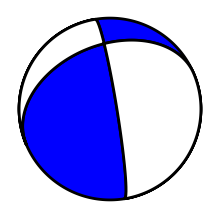

[45.74277419944782, 49.94361025435123]


In [ ]:
seed = np.random.randint(0, 2024)
np.random.seed(seed)
print(f'Seed: {seed}')

# np.random.seed(2024)
# np.random.seed(1513)
# np.random.seed(555)

# # BUG plot_iterates_2D (off by 1)
# np.random.seed(560)

# create random array for t, normalised to 1
t = fn.unit_vec(np.random.rand(3))

# create random array for p, normalised to 1
direc = fn.unit_vec(np.random.rand(3))
p = fn.starting_direc(t, direc)

# get truen params for synthetic test
true_params = fn.tp2sdr(t, p, True)[0]
print('Original params: ', true_params)

# plot corresponding beachball
beachball = fn.beachball(true_params)

# set up parameters for inversion
model = TauPyModel(model='ak135')  # velocity model
hdepth = 15  # km - assumed quake depth
epdist = 10  # degrees - epicentral distance
azimuth = 200  # degrees - azimuth of seismometer
arrivals = model.get_travel_times(source_depth_in_km=hdepth,
                        distance_in_degree=epdist, phase_list=['P', 'S'])
takeoff_angles = [a.takeoff_angle for a in arrivals]
print(takeoff_angles)
velocities = np.array([5.8000, 3.4600])

# NOTE: Be aware of more than one P/S arrival
# Plot beachball set: grid + ordered overlay
# Example events (Paula) --- Mars later
# Laplacians (finite differences)
# Moment tensor
# Alt cost function --- later

***
#### Hybrid Inversion
***

In [ ]:
importlib.reload(fn)
importlib.reload(sm)
importlib.reload(opt)
importlib.reload(mp)

# initialize model
inv_model = sm.SeismicModel(np.deg2rad(azimuth), takeoff_angles, velocities)
best_fit = inv_model(np.deg2rad(true_params), set_Ao=True)

# tune hyperparameters
config = opt.get_config()

# initialize random hybrid search: many runs
num_runs = 30
starts = fn.random_params(num_runs)

# # initialize systematic hybrid search: debugging
# step_size = 30
# starts = fn.systematic_params(step_size)
# num_runs = len(starts)

# multi-start optimization
inv_model.reset()
print_every = 10

for index, start in enumerate(starts):
    if print_every > 0 and index % print_every == 0:
        print(f'Run {index} of {num_runs}')
    opt.minimize(inv_model, config, start)
    
print(f'Convergence rate: {inv_model.convergence_rate():.0f}%')

Run 0 of 30
Run 10 of 30
Run 20 of 30
Convergence rate: 100%


Axis: T
Optimal parameters: [33.97489676 54.36058158  9.84739389]
Search error: 0.26996548286940075 degrees


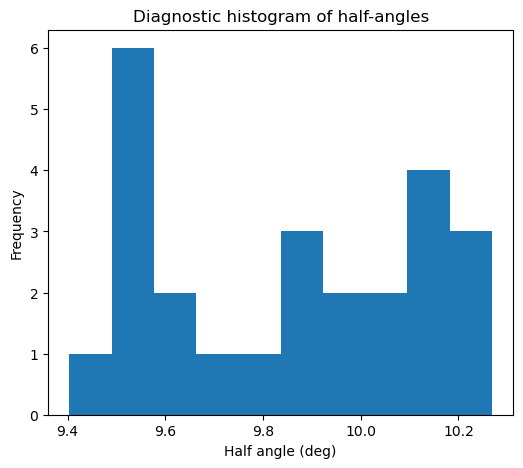

In [ ]:
params, error, position = inv_model.get_optimal_parameterization()
name = 'T' if position == 0 else 'P'

print(f'Axis: {name}')
print(f'Optimal parameters: {np.rad2deg(params)}')
print(f'Search error: {np.rad2deg(error)} degrees')

mp.half_angles(inv_model, bins=10)

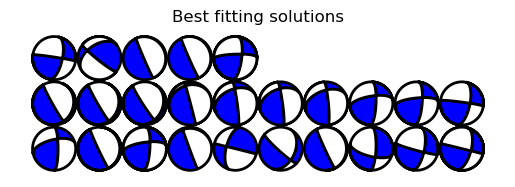

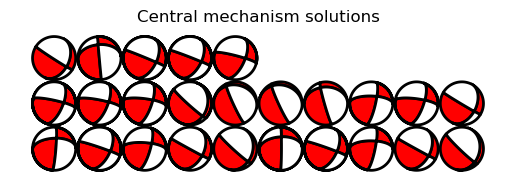

In [ ]:
# beachball plots
mp.beachballs(inv_model, central=False, order_by='strike')
mp.beachballs(inv_model, central=True, order_by='strike')

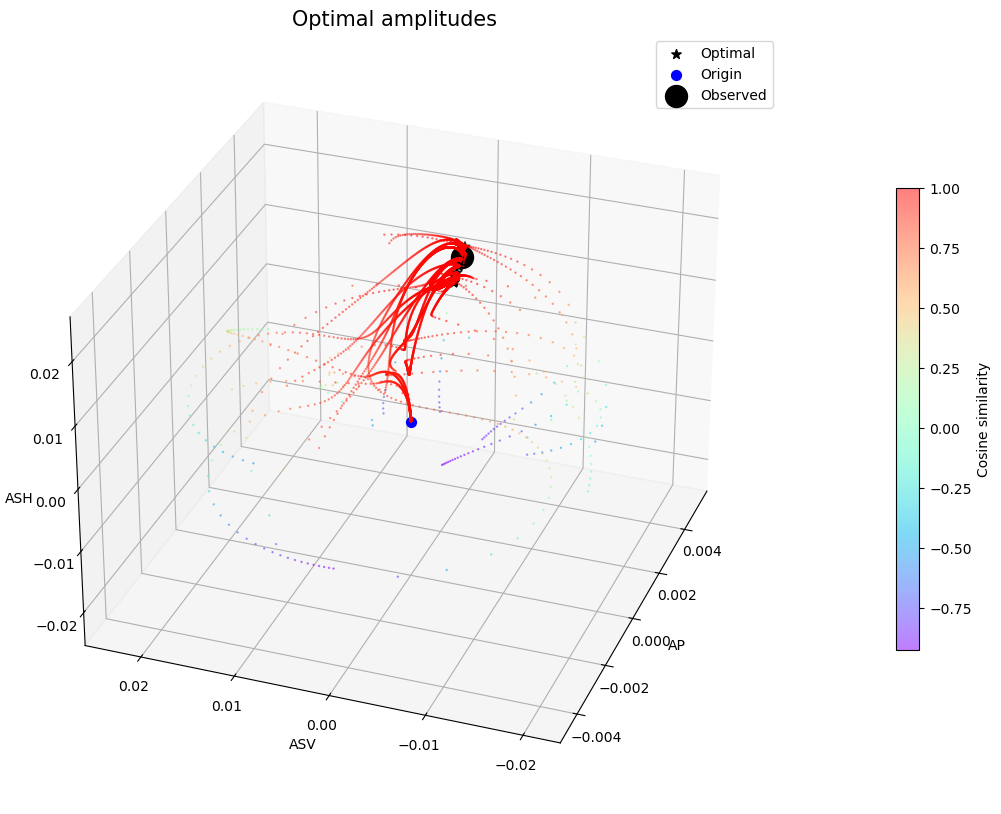

In [ ]:
# amplitude plot
# TODO: include marker at origin
mp.amplitudes(inv_model, azim=200, elev=30, s=50, alpha=0.5, iterates=True)

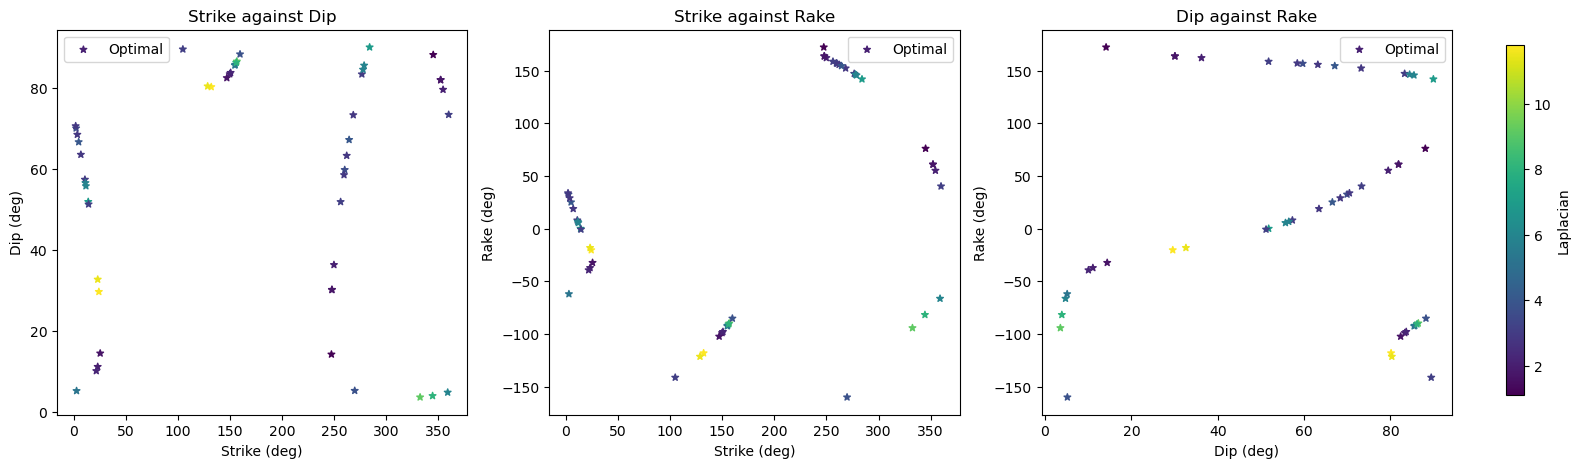

In [ ]:
# iterate plot - sdr space
mp.iterates_2D(inv_model, s=25, optimal=True, index=2, cmap='viridis')
# mp.iterates_2D(s=1, optimal=False, index=0)
# mp.iterates_2D(s=1, optimal=False, index=1)

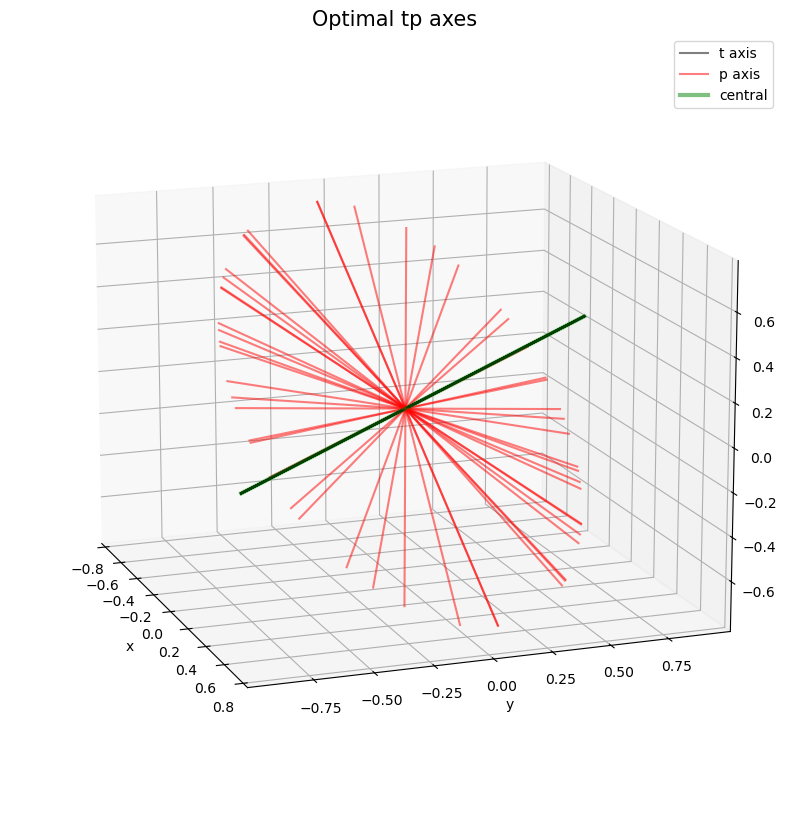

In [ ]:
# optimal plot - tp space, collapse to central
mp.tp_axes(inv_model, azim=-20, elev=15, half=False, central=True)

In [258]:
laplacian_flow = np.rad2deg(inv_model.laplacian_flow())
print(f"Laplacian flow: {laplacian_flow}")

Laplacian flow: [  0.         -33.65359615   9.50400742]


***
#### Uncertainty Propagation
***

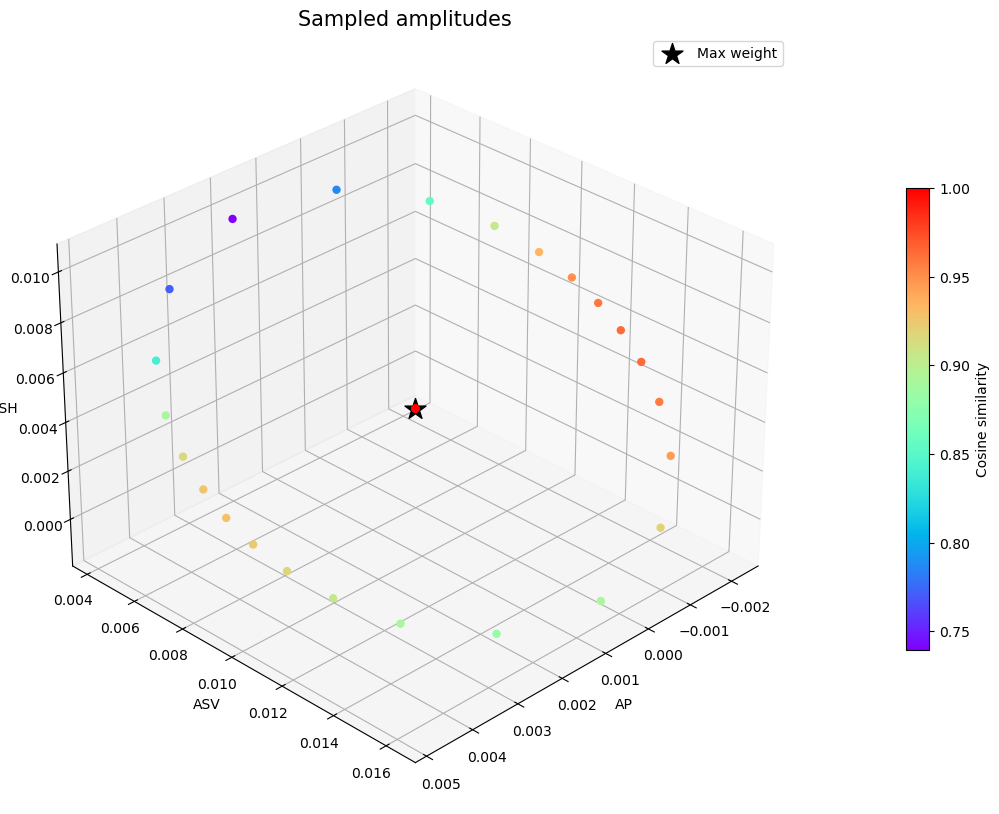

In [ ]:
dd, num_samples = 15, 25
# dd, num_samples = 30, 15  # debugging
inv_model.init_uncertainty()
inv_model.sample_amplitudes(dd, num_samples)
mp.sampled_amplitudes(inv_model, cmap='rainbow', s=25)

In [260]:
num_runs, print_every = 30, 0
inv_model.monte_carlo(dd, num_samples, num_runs, print_every)

Sample 0 of 29


Sample 1 of 29
Sample 2 of 29
Sample 3 of 29
Sample 4 of 29
Sample 5 of 29
Sample 6 of 29
Sample 7 of 29
Sample 8 of 29
Sample 9 of 29
Sample 10 of 29
Sample 11 of 29
Sample 12 of 29
Sample 13 of 29
Sample 14 of 29
Sample 15 of 29
Sample 16 of 29
Sample 17 of 29
Sample 18 of 29
Sample 19 of 29
Sample 20 of 29
Sample 21 of 29
Sample 22 of 29
Sample 23 of 29
Sample 24 of 29
Sample 25 of 29
Sample 26 of 29
Sample 27 of 29
Sample 28 of 29


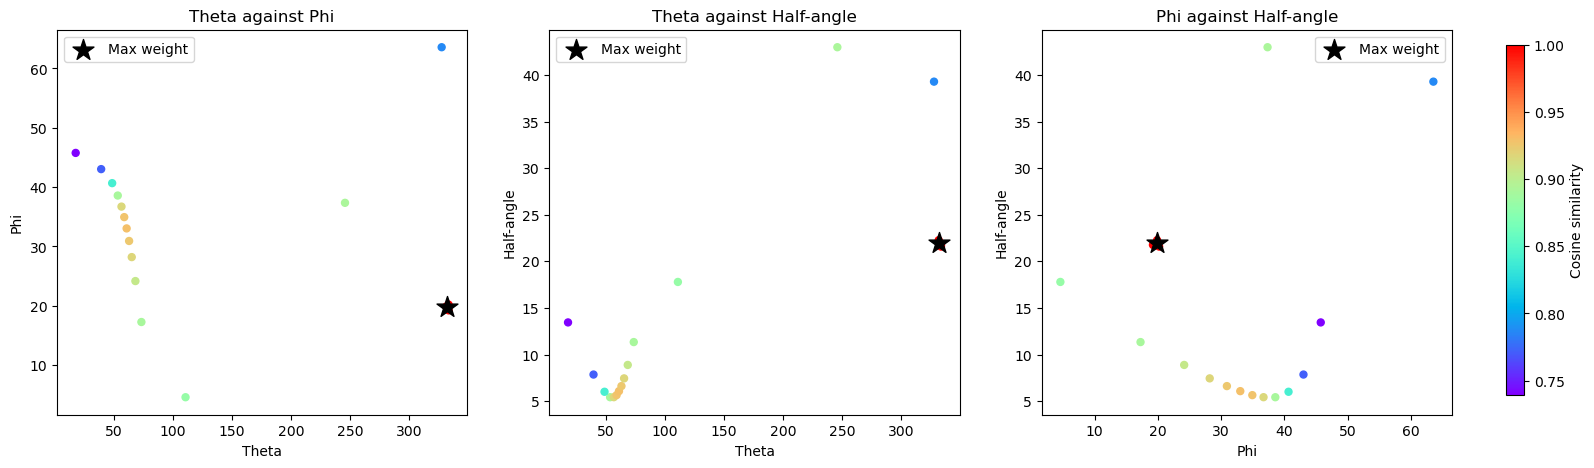

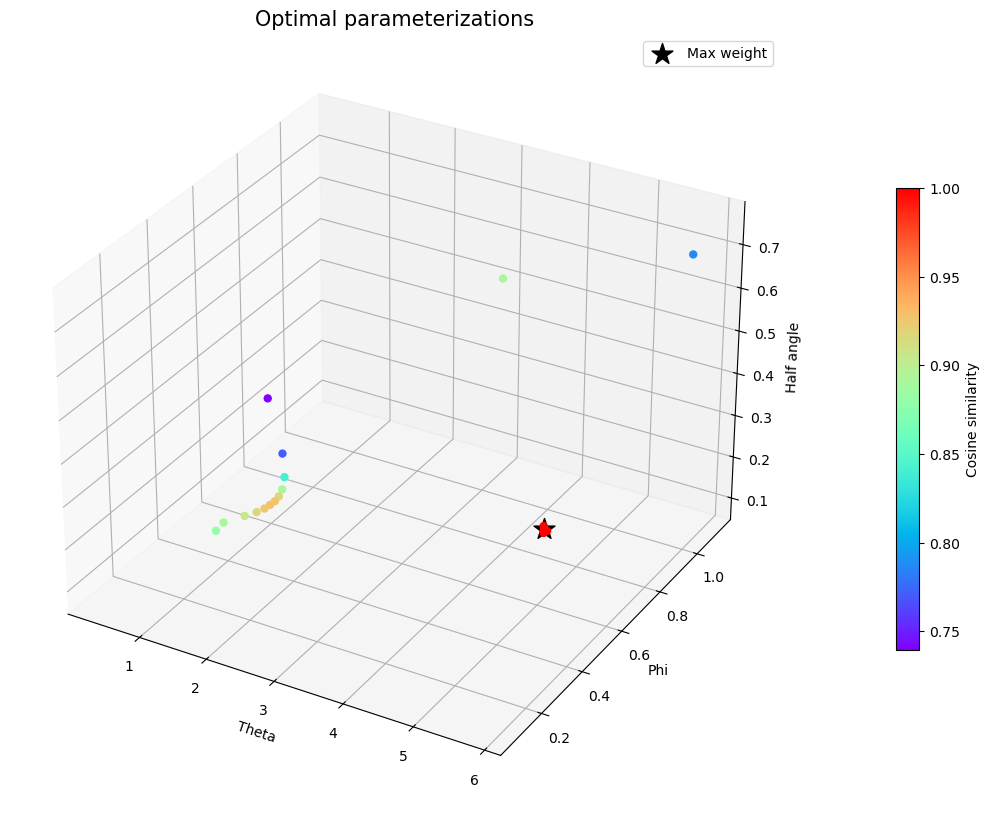

In [ ]:
# monte carlo plot - cone space
error_threshold = 5
inv_model.post_filter(threshold=error_threshold)
mp.uncertainty_2D(inv_model, s=25, scale=0)
# mp.uncertainty_3D(elev=30, azim=45, s=25)

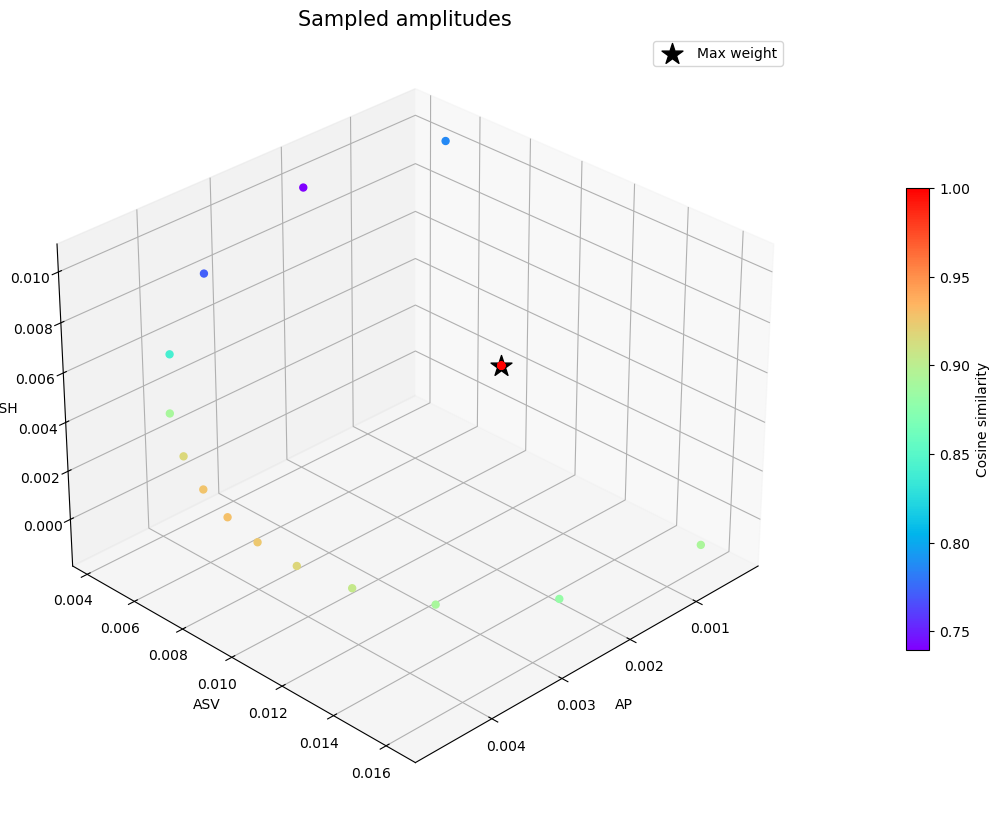

In [ ]:
mp.sampled_amplitudes(inv_model, cmap='rainbow', s=25)

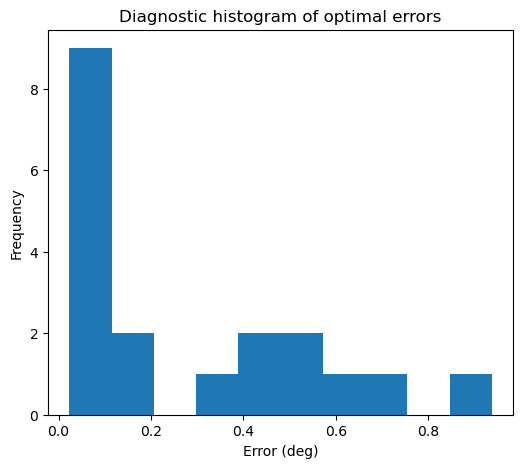

In [ ]:
# diagnostic plot of monte carlo errors
mp.optimal_errors(inv_model, bins=10)